=========  ===============================================<br>

    run                 task<br>
=========  ===============================================<br>
    1          Baseline, eyes open<br>
    2          Baseline, eyes closed<br>
3, 7, 11       Motor execution: left vs right hand<br>
4, 8, 12       Motor imagery: left vs right hand<br>
5, 9, 13       Motor execution: hands vs feet<br>
6, 10, 14      Motor imagery: hands vs feet<br>
=========  ===============================================<br>

In [1]:
# !pip install mne

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout', gpu=True):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if gpu:
        config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
        sess = tf.Session(config=config) 
        K.set_session(sess)
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same', input_shape = (1, Chans, Samples), use_bias = False, data_format='channels_first')(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D, data_format='channels_first', depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('relu')(block2)
    block2       = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    block3       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block2)
    block3       = BatchNormalization(axis = 1)(block3)
    block3       = Activation('relu')(block3)
    block3       = AveragePooling2D((1, 8), data_format='channels_first')(block3)
    block3       = dropoutType(dropoutRate)(block3)
    
    
    block4       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block3)
    block4       = BatchNormalization(axis = 1)(block4)
    block4       = Activation('relu')(block4)
    block4       = AveragePooling2D((1, 8), data_format='channels_first')(block4)
    block4       = dropoutType(dropoutRate)(block4)
    
    block5       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block4)
    block5       = BatchNormalization(axis = 1)(block5)
    block5       = Activation('elu')(block5)
    block5       = AveragePooling2D((1, 8), data_format='channels_first')(block5)
    block5       = dropoutType(dropoutRate)(block5)
    
#     block6       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block5)
#     block6       = BatchNormalization(axis = 1)(block6)
#     block6       = Activation('elu')(block6)
#     block6       = AveragePooling2D((1, 8), data_format='channels_first')(block6)
#     block6       = dropoutType(dropoutRate)(block6)
    
    
    flatten      = Flatten(name = 'flatten')(block5)
    
#     dense        = Dense(50,name='dense1', kernel_constraint = max_norm(norm_rate))(flatten)
    dense        = Dense(1, name = 'out', kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=softmax)

def my_EEGNet(input_shape, batch_size=1, n_classes=2):
    """
    My Special EEGNet
    
    Arguments:
        input_shape: (n_channels, sequence)
        batch_size : number of batches
        n_classes  : number of output classes
    
    """
    model = Sequential()
    
#     model.add(Input(input_shape, batch_size=batch_size, name='input'))
    model.add(Conv1D(60, 15, input_shape=input_shape, batch_size=batch_size, activation='relu', name='Conv1_1'))
    model.add(Conv1D(40, 15, activation='relu', name='Conv1_2'))
    model.add(MaxPooling1D(name='pooling1_1'))
    
    model.add(Conv1D(10, 10, input_shape=input_shape, batch_size=batch_size, activation='relu', name='Conv2_1'))
    model.add(Conv1D(15, 5, activation='relu', name='Conv2_2'))
    model.add(MaxPooling1D(name='pooling2_1'))
    
    model.add(Flatten())
    model.add(Dense(30 , activation='relu', name='Dense1'))
    model.add(Dense(1,activation='sigmoid', name='output'))
    
    return model

In [44]:
%load_ext autoreload
%autoreload

import numpy as np
from tensorflow.keras import *
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
import mne
import pandas as pd
from matplotlib import pyplot as plt 
from mne import time_frequency 
# from ipywidgets import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download dataset from https://physionet.org/pn4/eegmmidb/

In [10]:
def download_dataset(subjects, runs):
    raws_list = []
    for i in subjects:
        try:
            raws_list.append(eegbci.load_data(i, runs))
        except Exception as e:
            print(i,' => ' ,e)
            
    return raws_list

In [21]:
def load_dataset(subjects, runs):
  
  # check if dataset is downloaded
    download_dataset(subjects, runs)
  
    raw = None
  
    for i in subjects:
        for f in eegbci.load_data(i, runs):

            if raw is None:
                raw = read_raw_edf(f, preload=True)
            else:
                try:
                    raw = concatenate_raws([raw, read_raw_edf(f, preload=True)])
                except:
                    print('subject {} failed to concatinate'.format(i))

    return raw
  
def preprocess(raw, event_id, use_filter = True, low_freq=7, high_freq=30, tmin=1, tmax=2):
    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    if use_filter:
        raw.filter(low_freq, high_freq)


    events, _ = get_events(raw)

    picks = get_picks(raw)

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = get_epochs(raw, events, event_id)

    epochs_train = epochs.copy().crop(tmin=tmin, tmax=tmax)
    labels = epochs_train.events[:, -1] - 2

    labels = labels.reshape((labels.shape[0],1))
    epochs_data_train = epochs_train.get_data()
    epochs_data_train = epochs_data_train.reshape((epochs_data_train.shape[0],1, epochs_data_train.shape[1], epochs_data_train.shape[2]))

    return epochs_data_train, labels


def get_events(raw, event_id=dict(T1=2, T2=3)):
    return events_from_annotations(raw, event_id=event_id)

def get_picks(raw):
    return pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

def get_epochs(raw,events, event_id):
    return Epochs(raw, events, event_id, -1, 4, proj=True, picks=get_picks(raw),
                  baseline=(None, None), preload=True)
  
  


## Load Dataset

In [23]:
subjects = [i for i in range(1,2)]
runs = [4, 8, 12]  # Motor imagery: left hand vs right hand

raw = load_dataset(subjects, runs)
raw.get_data().shape

# raw = concatenate_raws(raw, load_dataset(subjects, [3, 7, 11]))

Extracting EDF parameters from C:\Users\Mehran\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Mehran\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Mehran\mne_data\MNE-eegbci-data\physiobank\database\eegmmidb\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


(64, 60000)

In [25]:
event_id = dict(left=2, right=3)
epochs_data_train, labels = preprocess(raw, event_id,use_filter=True,low_freq=5, high_freq=60, tmax=0.5, tmin=-0.2)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T1', 'T2']
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


## Plot the montage of sensors

<ipython-input-6-eaeb06de5617>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['T9', 'T10']. Their position has been left untouched.
  raw.set_montage(montage)


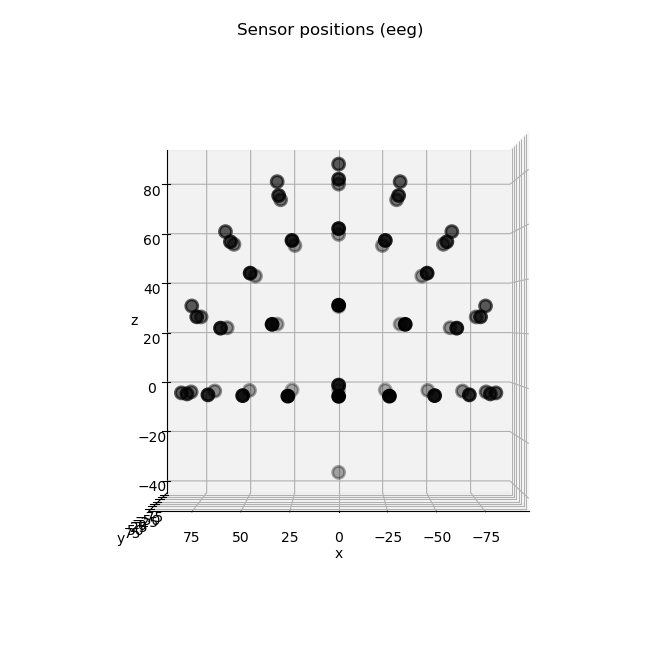

In [6]:
montage = mne.channels.read_montage('biosemi64')
%matplotlib qt5
raw.set_montage(montage)
raw.plot_sensors('3d')
# %matplotlib qt5
# raw.plot_psd(fmax=30)

# Visualizations

In [52]:
# df=pd.DataFrame(get_events(raw), columns = ['time','x','event'])
# df.head()
events, _ = get_events(raw)
epochs = get_epochs(raw, events, event_id)
epochs.info

Used Annotations descriptions: ['T1', 'T2']
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 5.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 60.0 Hz
    meas_date : tuple | 2009-08-12 16:15:00 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : N

NameError: name 'create_info' is not defined

Applying baseline correction (mode: mean)


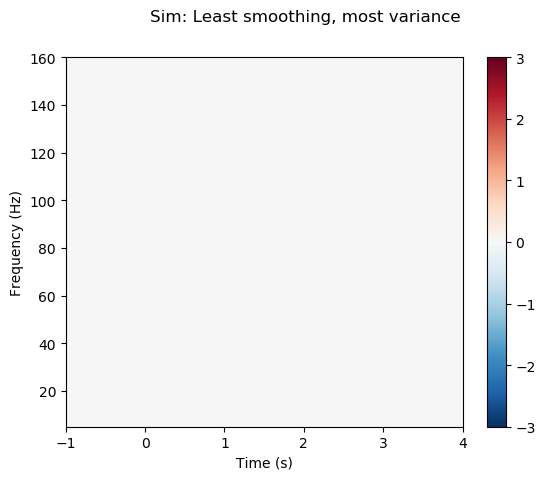

In [53]:
freqs = np.arange(5, 160., 2)
vmin, vmax = -3., 3.  # Define our color limits.

n_cycles = freqs / 2.
time_bandwidth = 2  # Least possible frequency-smoothing (1 taper)
power = time_frequency.tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
# Plot results. Baseline correct based on first 100 ms.
power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
           title='Sim: Least smoothing, most variance')

In [42]:
# fig, ax = plt.subplots()

# ax.scatter(df.index, df['event'])

# indexA = np.array(df.index[df['event']==3])
# for i in indexA:
#     ax.axvline(x=i, ymin=0, ymax=1, c='r', linestyle='--')

In [43]:
# mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp,
#                     event_id=event_id)

# plt.show()

In [0]:
# df.hist()

In [29]:
# # Extract data from the first 5 channels
n_ch = 5
sfreq = raw.info['sfreq']
data, times = raw[:n_ch, int(sfreq * 1):int(sfreq * 5)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T);
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-' + str(n_ch));
plt.legend(raw.ch_names[:n_ch]);

## Train test spilt 
### using mne method

In [32]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []

cv = ShuffleSplit(10, test_size=0.25, random_state=42)
cv_split = cv.split(epochs_data_train)

In [33]:
# c = []
# for train_idx, test_idx in cv_split:
#     y_train, y_test = labels[train_idx], labels[test_idx]
#     print(epochs_data_train[train_idx])
#     c.append(csp.fit_transform(epochs_data_train[train_idx], y_train))
# # c[0]

# Baseline models 

In [34]:
classifier = svm.SVC(gamma='auto')
# classifier = LogisticRegression(solver='lbfgs')
# classifier = LinearDiscriminantAnalysis()
# classifier = GaussianNB()
# classifier = LassoLarsCV()

In [35]:
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)

# # Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('Classifier', classifier)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# # Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# # plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

layout = read_layout('EEG1005')
csp.plot_patterns(epochs.info, layout=layout, ch_type='eeg',
                  units='Patterns (AU)', size=2)

Computing data rank from raw with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 1 dim * 9e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 1 dim * 8.2e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using EMPIRICAL
Done.


D:\InstalledApps\WindowsApps\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: shapes (1,1) and (1,64,113) not aligned: 1 (dim 1) != 64 (dim 1)

# Neural Network Implementation

In [13]:
X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)

print('shape of train-set-X: {} \nshape of test-set-X: {}'.format(X_train.shape, X_test.shape))
print('shape of train-set-y: {} \nshape of test-set-y: {}'.format(y_train.shape, y_test.shape))

shape of train-set-X: (2831, 1, 64, 321) 
shape of test-set-X: (708, 1, 64, 321)
shape of train-set-y: (2831, 1) 
shape of test-set-y: (708, 1)


In [37]:
batch_size = 50
# model = EEGNet.my_EEGNet(input_shape=(64,161), batch_size=None,n_classes=2)
# model = EEGNet.EEGNet(2,Samples=161, F1=8, kernLength=20)
model = EEGNet(2, Chans = 64, Samples = X_train.shape[-1], 
             dropoutRate = 0, kernLength = 96, F1 = 16, 
             D = 3, F2 = 48, norm_rate = 0.1, dropoutType = 'Dropout')
# model.summary()

In [38]:
optimizer = optimizers.Adam(lr=0.0001,decay=0.00003)
model.compile(optimizer , 'binary_crossentropy', metrics=['acc'])

In [39]:
# model.summary()

In [40]:
history = model.fit(X_train, y_train, batch_size=500,epochs=300,validation_data=(X_test, y_test))

Train on 2831 samples, validate on 708 samples
Epoch 1/300
2831/2831 [==============================] - 16s 6ms/sample - loss: 0.6932 - acc: 0.4903 - val_loss: 0.6932 - val_acc: 0.4816
Epoch 2/300


ResourceExhaustedError: OOM when allocating tensor with shape[500,16,64,321] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_2/Adam/gradients/depthwise_conv2d_2_1/depthwise_grad/DepthwiseConv2dNativeBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
# plt.legend((history.history['acc'],history.history['loss']), ('Accuracy', 'Loss'),)

In [0]:
model.save('model_' + str(X_train.shape[-1]) + '.h5')

In [0]:
np.mean(y_test == (model.predict(X_test) > 0.5))

0.807909604519774

In [0]:
test_epochs, test_labels = preprocess(load_dataset([i for i in range(95,100)], runs), event_id, use_filter=False, tmax=2.5, tmin=0.5)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S095/S095R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S095/S095R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S095/S095R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S096/S096R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [ ]:
def my_EEGNet(channels=64, samples=321, dropoutRate=0.0, n_classes=2):
    """
    My Special EEGNet
    
    Arguments:
        input_shape: (n_channels, sequence)
        batch_size : number of batches
        n_classes  : number of output classes
    
    """
    input_shape = (1, channels, samples)
    model = Sequential()
    
#     model.add(Input(input_shape, name='input'))
    model.add(Conv2D(16, (1, channels), padding='same',input_shape=input_shape, data_format='channels_first', name='Conv1_1'))
    model.add(BatchNormalization(axis=1))
    model.add(DepthwiseConv2D((channels, 1), padding='valid',data_format='channels_first', depth_multiplier=3))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 4),data_format='channels_first', name='pooling1'))
    model.add(Dropout(dropoutRate))
    
    model.add(SeparableConv2D(48, (1, 16), padding='same', data_format='channels_first'))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 8),data_format='channels_first', name='pooling2'))
    model.add(Dropout(dropoutRate))
    
    
#     model.add(Flatten())
#     model.add(Dense(30 , activation='relu', name='Dense1'))
#     model.add(Dense(1,activation='sigmoid', name='output'))
    
    return model

In [0]:
np.mean(test_labels == (model.predict(test_epochs) > 0.5))

0.8266666666666667

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K


def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout', gpu=True):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if gpu:
        config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
        sess = tf.Session(config=config) 
        K.set_session(sess)
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same', input_shape = (1, Chans, Samples), use_bias = True, data_format='channels_first')(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = True, depth_multiplier = D, data_format='channels_first', depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16), use_bias = True, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('relu')(block2)
    block2       = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    block3       = SeparableConv2D(F2, (1, 16), use_bias = True, padding = 'same')(block2)
    block3       = BatchNormalization(axis = 1)(block3)
    block3       = Activation('relu')(block3)
    block3       = AveragePooling2D((1, 8), data_format='channels_first')(block3)
    block3       = dropoutType(dropoutRate)(block3)
    
    
    block4       = SeparableConv2D(F2, (1, 16), use_bias = True, padding = 'same')(block3)
    block4       = BatchNormalization(axis = 1)(block4)
    block4       = Activation('relu')(block4)
    block4       = AveragePooling2D((1, 8), data_format='channels_first')(block4)
    block4       = dropoutType(dropoutRate)(block4)
    
    block5       = SeparableConv2D(F2, (1, 16), use_bias = True, padding = 'same')(block4)
    block5       = BatchNormalization(axis = 1)(block5)
    block5       = Activation('elu')(block5)
    block5       = AveragePooling2D((1, 8), data_format='channels_first')(block5)
    block5       = dropoutType(dropoutRate)(block5)
    
#     block6       = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block5)
#     block6       = BatchNormalization(axis = 1)(block6)
#     block6       = Activation('elu')(block6)
#     block6       = AveragePooling2D((1, 8), data_format='channels_first')(block6)
#     block6       = dropoutType(dropoutRate)(block6)
    
    
    flatten      = Flatten(name = 'flatten')(block5)
    
#     dense        = Dense(50,name='dense1', kernel_constraint = max_norm(norm_rate))(flatten)
    dense        = Dense(1, name = 'out', kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('sigmoid', name = 'sigmoid')(dense)
    
    return Model(inputs=input1, outputs=softmax)



In [117]:
model = EEGNet(2, Samples=321,kernLength=96, Chans=64, F1=16, D=3, F2=48, dropoutRate=0, norm_rate=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1, 64, 321)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 64, 321)       1552      
_________________________________________________________________
batch_normalization_v1_136 ( (None, 16, 64, 321)       64        
_________________________________________________________________
depthwise_conv2d_47 (Depthwi (None, 48, 1, 321)        3120      
_________________________________________________________________
batch_normalization_v1_137 ( (None, 48, 1, 321)        192       
_________________________________________________________________
activation_89 (Activation)   (None, 48, 1, 321)        0         
_________________________________________________________________
average_pooling2d_32 (Averag (None, 48, 1, 80)         0         
__________